# Computation on Arrays: Broadcasting

We saw in [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb) how NumPy's universal functions can be used to *vectorize* operations and thereby remove slow Python loops.
This chapter discusses *broadcasting*: a set of rules by which NumPy lets you apply binary operations (e.g., addition, subtraction, multiplication, etc.) between arrays of different sizes and shapes.

## Introducing Broadcasting

Recall that for arrays of the same size, binary operations are performed on an element-by-element basis:

In [1]:
import numpy as np

In [2]:
a = np.array([0, 1, 2])
b = np.array([5, 5, 5])
a + b

array([5, 6, 7])

Broadcasting allows these types of binary operations to be performed on arrays of different sizes—for example, we can just as easily add a scalar (think of it as a zero-dimensional array) to an array:

In [3]:
a + 5

array([5, 6, 7])

We can think of this as an operation that stretches or duplicates the value `5` into the array `[5, 5, 5]`, and adds the results.

We can similarly extend this idea to arrays of higher dimension. Observe the result when we add a one-dimensional array to a two-dimensional array:

In [4]:
M = np.ones((3, 3))
M

array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]])

In [5]:
M + a

array([[1., 2., 3.],
       [1., 2., 3.],
       [1., 2., 3.]])

Here the one-dimensional array `a` is stretched, or broadcasted, across the second dimension in order to match the shape of `M`.

While these examples are relatively easy to understand, more complicated cases can involve broadcasting of both arrays. Consider the following example:

In [6]:
a = np.arange(3)
b = np.arange(3)[:, np.newaxis]

print(a)
print(b)

[0 1 2]
[[0]
 [1]
 [2]]


In [7]:
a + b

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

Just as before we stretched or broadcasted one value to match the shape of the other, here we've stretched *both* `a` and `b` to match a common shape, and the result is a two-dimensional array!
The geometry of these examples is visualized in the following figure. (Code to produce this plot can be found in the online [appendix](https://github.com/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/06.00-Figure-Code.ipynb#Broadcasting), and is adapted from a source published in the [astroML](http://astroml.org) documentation. Used by permission.)

![Broadcasting Visual](images/02.05-broadcasting.png)

The light boxes represent the broadcasted values. This way of thinking about broadcasting may raise questions about its efficiency in terms of memory use, but worry not: NumPy broadcasting does not actually copy the broadcasted values in memory. Still, this can be a useful mental model as we think about broadcasting.

## Rules of Broadcasting

Broadcasting in NumPy follows a strict set of rules to determine the interaction between the two arrays:

- Rule 1: If the two arrays differ in their number of dimensions, the shape of the one with fewer dimensions is *padded* with ones on its leading (left) side.
- Rule 2: If the shape of the two arrays does not match in any dimension, the array with shape equal to 1 in that dimension is stretched to match the other shape.
- Rule 3: If in any dimension the sizes disagree and neither is equal to 1, an error is raised.

To make these rules clear, let's consider a few examples in detail.

### Broadcasting Example 1

Suppose we want to add a two-dimensional array to a one-dimensional array:

In [8]:
M = np.ones((2, 3))
a = np.arange(3)

Let's consider an operation on these two arrays, which have the following shapes:

- `M.shape` is `(2, 3)`
- `a.shape` is `(3,)`

We see by rule 1 that the array `a` has fewer dimensions, so we pad it on the left with ones:

- `M.shape` remains `(2, 3)`
- `a.shape` becomes `(1, 3)`

By rule 2, we now see that the first dimension disagrees, so we stretch this dimension to match:

- `M.shape` remains `(2, 3)`
- `a.shape` becomes `(2, 3)`

The shapes now match, and we see that the final shape will be `(2, 3)`:

In [9]:
M + a

array([[1., 2., 3.],
       [1., 2., 3.]])

### Broadcasting Example 2

Now let's take a look at an example where both arrays need to be broadcast:

In [10]:
a = np.arange(3).reshape((3, 1))
b = np.arange(3)

Again, we'll start by determining the shapes of the arrays:

- `a.shape` is `(3, 1)`
- `b.shape` is `(3,)`

Rule 1 says we must pad the shape of `b` with ones:

- `a.shape` remains `(3, 1)`
- `b.shape` becomes `(1, 3)`

And rule 2 tells us that we must upgrade each of these ``1``s to match the corresponding size of the other array:

- `a.shape` becomes `(3, 3)`
- `b.shape` becomes `(3, 3)`

Because the results match, these shapes are compatible. We can see this here:

In [11]:
a + b

array([[0, 1, 2],
       [1, 2, 3],
       [2, 3, 4]])

### Broadcasting Example 3

Next, let's take a look at an example in which the two arrays are not compatible:

In [12]:
M = np.ones((3, 2))
a = np.arange(3)

This is just a slightly different situation than in the first example: the matrix `M` is transposed.
How does this affect the calculation? The shapes of the arrays are as follows:

- `M.shape` is `(3, 2)`
- `a.shape` is `(3,)`

Again, rule 1 tells us that we must pad the shape of `a` with ones:

- `M.shape` remains `(3, 2)`
- `a.shape` becomes `(1, 3)`

By rule 2, the first dimension of `a` is then stretched to match that of `M`:

- `M.shape` remains `(3, 2)`
- `a.shape` becomes `(3, 3)`

Now we hit rule 3—the final shapes do not match, so these two arrays are incompatible, as we can observe by attempting this operation:

In [13]:
M + a

ValueError: operands could not be broadcast together with shapes (3,2) (3,) 

Note the potential confusion here: you could imagine making `a` and `M` compatible by, say, padding `a`'s shape with ones on the right rather than the left.
But this is not how the broadcasting rules work!
That sort of flexibility might be useful in some cases, but it would lead to potential areas of ambiguity.
If right-side padding is what you'd like, you can do this explicitly by reshaping the array (we'll use the `np.newaxis` keyword introduced in [The Basics of NumPy Arrays](02.02-The-Basics-Of-NumPy-Arrays.ipynb) for this):

In [14]:
a[:, np.newaxis].shape

(3, 1)

In [15]:
M + a[:, np.newaxis]

array([[1., 1.],
       [2., 2.],
       [3., 3.]])

Also notice that while we've been focusing on the `+` operator here, these broadcasting rules apply to *any* binary ufunc.
For example, here is the `logaddexp(a, b)` function, which computes `log(exp(a) + exp(b))` with more precision than the naive approach:

In [16]:
np.logaddexp(M, a[:, np.newaxis])

array([[1.31326169, 1.31326169],
       [1.69314718, 1.69314718],
       [2.31326169, 2.31326169]])

For more information on the many available universal functions, refer to [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb).

## Broadcasting in Practice

Broadcasting operations form the core of many examples you'll see throughout this book.
We'll now take a look at some instances of where they can be useful.

### Centering an Array

In [Computation on NumPy Arrays: Universal Functions](02.03-Computation-on-arrays-ufuncs.ipynb), we saw that ufuncs allow a NumPy user to remove the need to explicitly write slow Python loops. Broadcasting extends this ability.
One commonly seen example in data science is subtracting the row-wise mean from an array of data.
Imagine we have an array of 10 observations, each of which consists of 3 values.
Using the standard convention (see [Data Representation in Scikit-Learn](05.02-Introducing-Scikit-Learn.ipynb#Data-Representation-in-Scikit-Learn)), we'll store this in a $10 \times 3$ array:

In [17]:
rng = np.random.default_rng(seed=1701)
X = rng.random((10, 3))

We can compute the mean of each column using the `mean` aggregate across the first dimension:

In [18]:
Xmean = X.mean(0)
Xmean

array([0.38503638, 0.36991443, 0.63896043])

And now we can center the `X` array by subtracting the mean (this is a broadcasting operation):

In [19]:
X_centered = X - Xmean

To double-check that we've done this correctly, we can check that the centered array has a mean near zero:

In [20]:
X_centered.mean(0)

array([ 4.99600361e-17, -4.44089210e-17,  0.00000000e+00])

To within machine precision, the mean is now zero.

### Plotting a Two-Dimensional Function

One place that broadcasting often comes in handy is in displaying images based on two-dimensional functions.
If we want to define a function $z = f(x, y)$, broadcasting can be used to compute the function across the grid:

In [21]:
# x and y have 50 steps from 0 to 5
x = np.linspace(0, 5, 50)
y = np.linspace(0, 5, 50)[:, np.newaxis]

z = np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x)

We'll use Matplotlib to plot this two-dimensional array, shown in the following figure (these tools will be discussed in full in [Density and Contour Plots](04.04-Density-and-Contour-Plots.ipynb)):

In [22]:
%matplotlib inline
import matplotlib.pyplot as plt

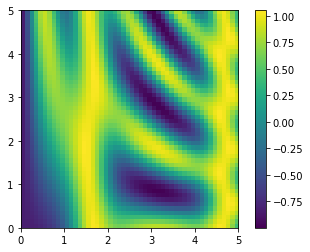

In [23]:
plt.imshow(z, origin='lower', extent=[0, 5, 0, 5])
plt.colorbar();

The result is a compelling visualization of the two-dimensional function.